In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import glob
from scipy.signal import find_peaks
from scipy.signal import peak_widths

# Filter out the light-adapted strips

In [2]:

# output\trial_1\081624_rois_metadata_bignine.csv
metadata_all = pd.read_csv("./output/trial_1/081624_rois_metadata_bignine.csv")

metadata = metadata_all.copy()

# remove the light adapted strips. 
# 1. lower case the filename
metadata['filename'] = metadata['filename'].str.lower()
print(f"Before filtering out light-adapted images there are {len(metadata['filename'])} strips in the metadata.\n")

# 2. remove rows that don't contain 'dark'
metadata = metadata[metadata['filename'].str.contains('dark')]
print(f"After filtering, there are {len(metadata['filename'])} remaining.\n")

# get the strip numbers of the dark adapted strips
strip_filenames = metadata['strip_filename'].unique()

print(f"These are the remaining strips:")
for strip in metadata['strip_filename'].unique():
    print(f"\t{strip}")
    
# get the strips that were filtered out by comparing the strip_filenames in the metadata_all with the strip_numbers
filtered_out = metadata_all[~metadata_all['strip_filename'].isin(strip_filenames)]

print(f"These are the strips that were filtered out:")
for strip in filtered_out['strip_filename'].unique():
    print(f"\t{strip}")
    
    
# create a list of the isolated numbers from the strip filenames
strip_numbers = [int(strip.strip(".png").split('_')[-1]) for strip in strip_filenames]
print(f"\nThese are the strip numbers of the remaining strips: {strip_numbers}")

Before filtering out light-adapted images there are 9 strips in the metadata.

After filtering, there are 8 remaining.

These are the remaining strips:
	strip_106.png
	strip_134.png
	strip_135.png
	strip_161.png
	strip_176.png
	strip_187.png
	strip_229.png
	strip_232.png
These are the strips that were filtered out:
	strip_101.png

These are the strip numbers of the remaining strips: [106, 134, 135, 161, 176, 187, 229, 232]


# Filter the lumen df to only include the dark-adapted strips.

In [3]:
# load the lumen datafile with pd
lumen_data = pd.read_csv("./output/trial_1/csv/lumen_1.csv")

# print the length of the df 
print(f"Before filtering out the light-adapted strips, there are {len(lumen_data)} rows in the lumen data.\n")

# get the lumen data for the strips that were not filtered out
lumen_data = lumen_data[lumen_data['strip'].isin(strip_numbers)]

print(f"After filtering, there are {len(lumen_data)} remaining.\n")

Before filtering out the light-adapted strips, there are 5366 rows in the lumen data.

After filtering, there are 4907 remaining.



# get the threshold metadata so we can reference it

In [4]:
th_metadata = pd.read_csv("./output/trial_1/threshold_metadata_1.csv", index_col=0)
th_metadata["process"] = th_metadata.index
print(th_metadata.head())

          method  morph_key  equalize  blur  thresh  maxval  blocksize  c  \
0_simple  simple  closeOpen      True  True      70     130         25  2   
1_simple  simple  closeOpen      True  True      70     255         25  2   
2_simple  simple  closeOpen      True  True      80     130         25  2   
3_simple  simple  closeOpen      True  True      80     255         25  2   
4_simple  simple  closeOpen      True  True      90     130         25  2   

                                                 morph_args  offset       key  \
0_simple  {'name': 'closeOpen', 'closing_kernel': array(...     1.0  0_simple   
1_simple  {'name': 'closeOpen', 'closing_kernel': array(...     1.0  1_simple   
2_simple  {'name': 'closeOpen', 'closing_kernel': array(...     1.0  2_simple   
3_simple  {'name': 'closeOpen', 'closing_kernel': array(...     1.0  3_simple   
4_simple  {'name': 'closeOpen', 'closing_kernel': array(...     1.0  4_simple   

           process  
0_simple  0_simple  
1_simple

# calculate the mean width of the lumen, grouped by the process

92
process
11_adaptive    6.816962
11_simple      6.376741
13_adaptive    6.921084
13_simple      9.613576
145_otsu       6.053237
Name: lumen_width_nm, dtype: float64


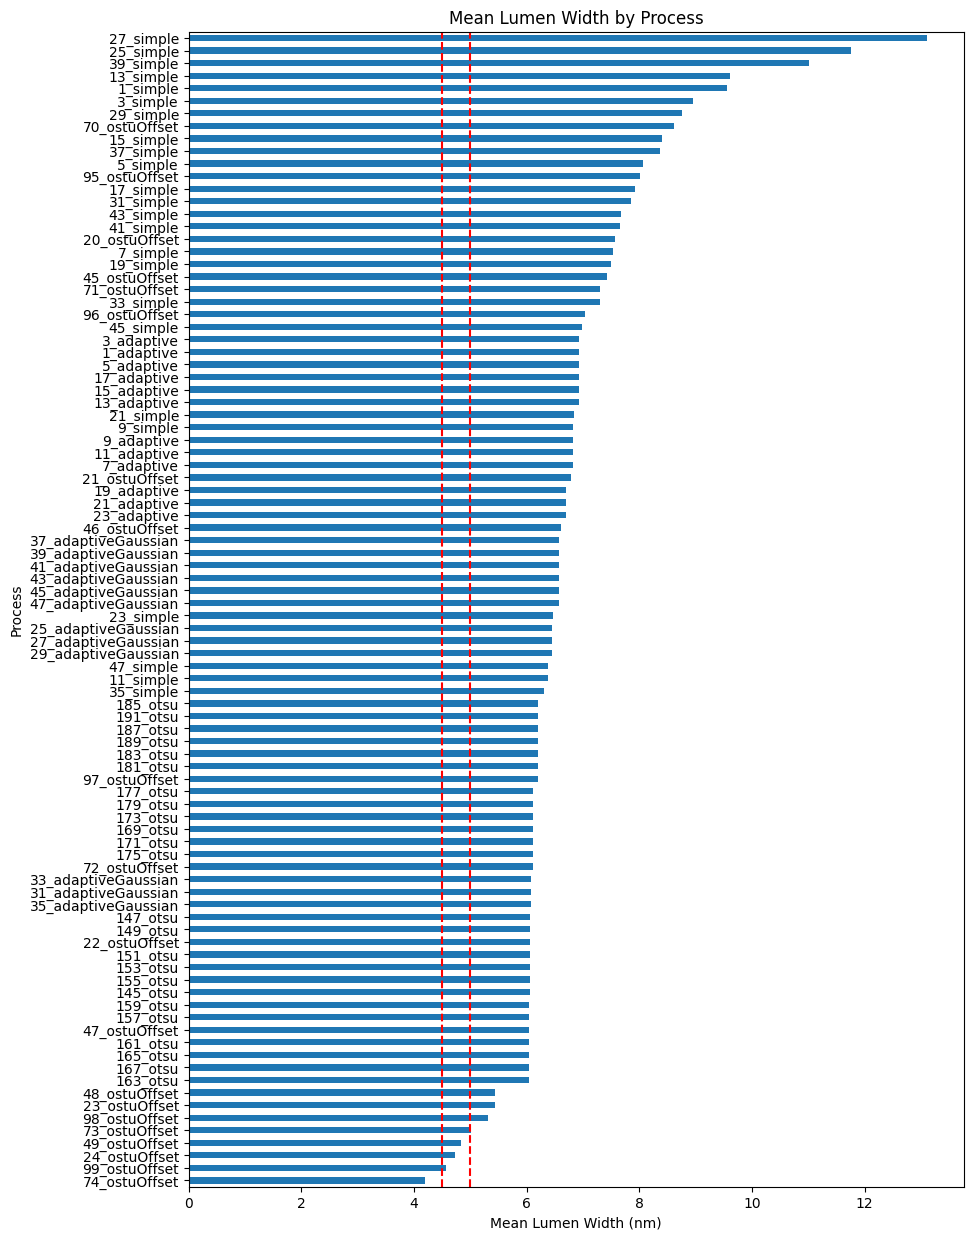

In [5]:

# we need to get the mean width of the lumen for each image, but grouped by process. this is a groupby operation
mean_widths = lumen_data.groupby('process')['lumen_width_nm'].mean()

print(len(mean_widths))
print(mean_widths.head())

# sort the mean widths
mean_widths = mean_widths.sort_values()
expected_range = [4.5, 5]

# plot the mean widths. figsize the first number is the width, the second is the height
plt.figure(figsize=(10, 15))
mean_widths.plot(kind='barh')
plt.xlabel('Mean Lumen Width (nm)')
plt.ylabel('Process')
plt.title('Mean Lumen Width by Process')

# mark a dashed vertical line at the low and high end of the expected range
plt.axvline(expected_range[0], color='r', linestyle='--')
plt.axvline(expected_range[1], color='r', linestyle='--')

plt.show()

# Take a closer look at those in the range

In [6]:
# print the processes in mean_width that are within the range +/- 0.5 nm
adjusted_range = [expected_range[0] - 0.5, expected_range[1] + 0.5]
adj_mean_widths = mean_widths[mean_widths.between(adjusted_range[0], adjusted_range[1])]
print(adj_mean_widths)
print(type(adj_mean_widths))

process
74_ostuOffset    4.191015
99_ostuOffset    4.560550
24_ostuOffset    4.727182
49_ostuOffset    4.843261
73_ostuOffset    5.005212
98_ostuOffset    5.306390
23_ostuOffset    5.433558
48_ostuOffset    5.445176
Name: lumen_width_nm, dtype: float64
<class 'pandas.core.series.Series'>


In [7]:
# get the index for the processes that are within the range
adj_processes = adj_mean_widths.index
print(adj_processes)

Index(['74_ostuOffset', '99_ostuOffset', '24_ostuOffset', '49_ostuOffset',
       '73_ostuOffset', '98_ostuOffset', '23_ostuOffset', '48_ostuOffset'],
      dtype='object', name='process')


In [8]:
# take the index of the th_metadata and create a column
th_metadata['in_range'] = th_metadata.index.isin(adj_processes)
print(len(th_metadata))

# filter the th_metadata to only include the processes that are in the range
df = th_metadata[th_metadata['in_range']].copy()
print(len(df))

340
8


# The best results

In [9]:
# merge the series into the df, joining on the process column
df = df.merge(adj_mean_widths, left_on='process', right_index=True)
df

,method,morph_key,equalize,blur,thresh,maxval,blocksize,c,morph_args,offset,key,process,in_range,lumen_width_nm
23_ostuOffset,ostuOffset,closeOpen,True,True,100,255,25,2,"{'name': 'closeOpen', 'closing_kernel': array(...",1.1,23_ostuOffset,23_ostuOffset,True,5.433558
24_ostuOffset,ostuOffset,closeOpen,True,True,100,255,25,2,"{'name': 'closeOpen', 'closing_kernel': array(...",1.2,24_ostuOffset,24_ostuOffset,True,4.727182
48_ostuOffset,ostuOffset,closeOpen,True,False,100,255,25,2,"{'name': 'closeOpen', 'closing_kernel': array(...",1.1,48_ostuOffset,48_ostuOffset,True,5.445176
49_ostuOffset,ostuOffset,closeOpen,True,False,100,255,25,2,"{'name': 'closeOpen', 'closing_kernel': array(...",1.2,49_ostuOffset,49_ostuOffset,True,4.843261
73_ostuOffset,ostuOffset,closeOpen,False,True,100,255,25,2,"{'name': 'closeOpen', 'closing_kernel': array(...",1.1,73_ostuOffset,73_ostuOffset,True,5.005212
74_ostuOffset,ostuOffset,closeOpen,False,True,100,255,25,2,"{'name': 'closeOpen', 'closing_kernel': array(...",1.2,74_ostuOffset,74_ostuOffset,True,4.191015
98_ostuOffset,ostuOffset,closeOpen,False,False,100,255,25,2,"{'name': 'closeOpen', 'closing_kernel': array(...",1.1,98_ostuOffset,98_ostuOffset,True,5.306390
99_ostuOffset,ostuOffset,closeOpen,False,False,100,255,25,2,"{'name': 'closeOpen', 'closing_kernel': array(...",1.2,99_ostuOffset,99_ostuOffset,True,4.560550


# Next steps
1. Repeat application of threshold, but with a focus on the offset only.
2. Go with thresh 100, maxval 255, and offset between 1.0 and 1.5, in small increments.  

In [10]:
# generate a range of offset values, in very small increments
offsets = np.arange(1.0, 1.5, 0.025)
print(offsets)

[1.    1.025 1.05  1.075 1.1   1.125 1.15  1.175 1.2   1.225 1.25  1.275
 1.3   1.325 1.35  1.375 1.4   1.425 1.45  1.475]
